In [65]:
# First, let's make sure that PyTorch is installed correctly.
# This example is from https://pytorch.org/get-started/locally/
# It should print out a tensor.

from __future__ import print_function
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.7462, 0.7926, 0.6531],
        [0.4598, 0.0252, 0.7995],
        [0.4602, 0.0675, 0.8980],
        [0.3664, 0.0887, 0.0321],
        [0.2136, 0.3004, 0.6919]])


In [66]:
# Transforms.
# Following this article:
# https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce

from torchvision import transforms

# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [107]:
# Loading test data.

from torchvision import datasets
from torch.utils.data import DataLoader

traindir = 'datadir/train/'
validdir = 'datadir/valid/'
testdir = 'datadir/test/'

# Change to fit hardware
# batch_size = 128
# But this gave me:
# RuntimeError: $ Torch: not enough memory: you tried to allocate 13GB. Buy new RAM!
# at /opt/conda/conda-bld/pytorch-cpu_1532578932944/work/aten/src/TH/THGeneral.cpp:204
batch_size = 16

# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'valid':
    datasets.ImageFolder(root=validdir, transform=image_transforms['valid']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['valid'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fe4b024a908>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fe4b024a048>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7fe49fde07b8>}


In [108]:
import pandas as pd
import os
import numpy as np

# Image manipulations
from PIL import Image

# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()
cat_df.tail()
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

There are 3 different classes.


3

In [109]:
# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

# The shape of a batch is (batch_size, color_channels, height, width).

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [110]:
# Should be False if no GPU support.

from torch import optim, cuda
train_on_gpu = cuda.is_available()
print(train_on_gpu)

multi_gpu = False
# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

False


In [111]:
# PyTorch has a number of models that have already been trained on millions of images from 1000 classes in Imagenet.
# https://pytorch.org/docs/stable/torchvision/models.html

from torchvision import models
model = models.vgg16(pretrained=True)
print(model)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Transfer learning.

import torch.nn as nn

n_inputs = model.classifier[6].in_features

# Add on classifier.
# For the VGG-16, we’re only changing the very last original fully-connected layer.
# All of the weights in the convolutional layers and the the first 5 fully-connected layers are not trainable.
model.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

# Only training classifier[6]
model.classifier

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_features=256, out_features=3, bias=True)
    (4): LogSoftmax()
  )
)

In [112]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,310,147 total parameters.
1,049,603 training parameters.


In [113]:
# The optimizer is Adam,
# an efficient variant of gradient descent that generally does not require hand-tuning the learning rate.

from torch import optim

# Loss and optimizer
criteration = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [114]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

In [115]:
# To keep track of the predictions made by the model, we create a mapping of classes to indexes and indexes to classes.
# This will let us know the actual class for a given prediction.

model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'faces'), (1, 'motorbikes'), (2, 'planes')]

In [116]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

# Below we can look at the parameters (weights) that will be updated by the optimizer during training.

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([3, 256])
torch.Size([3])


In [134]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    print(
                        f'\nValid loss: {valid_loss:.10f} < valid loss min {valid_loss_min:.10f}'
                    )
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [118]:
from timeit import default_timer as timer

save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 572.55 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.0104 	Validation Loss: 0.0000
		Training Accuracy: 99.43%	 Validation Accuracy: 100.00%
Epoch: 3	100.00% complete. 561.25 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.0007 	Validation Loss: 0.0000
		Training Accuracy: 100.00%	 Validation Accuracy: 100.00%
Epoch: 5	100.00% complete. 665.00 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.0011 	Validation Loss: 0.0000
		Training Accuracy: 99.90%	 Validation Accuracy: 100.00%
Epoch: 7	100.00% complete. 574.48 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.0004 	Validation Loss: 0.0000
		Training Accuracy: 100.00%	 Validation Accuracy: 100.00%
Epoch: 9	100.00% complete. 556.49 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.0032 	Validation Loss: 0.0000
		Training Accuracy: 99.81%	 Validation Accuracy: 100.00%
Epoch: 11	100.00% complete. 556.13 seconds elapsed in epoch.
Epoch: 11 	Training Loss: 0.0

Text(0.5,1,'Training and Validation Losses')

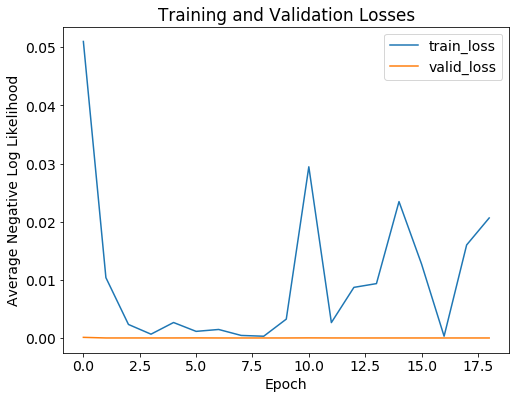

In [121]:
# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5,1,'Training and Validation Accuracy')

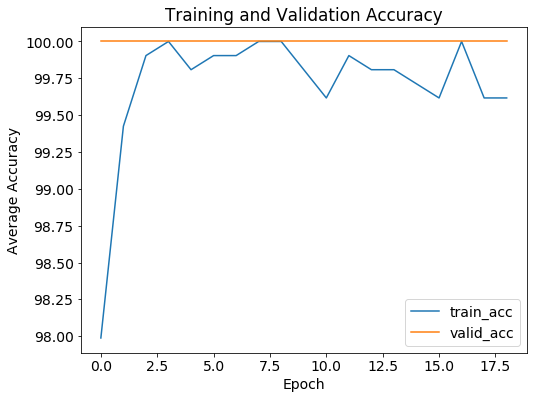

In [122]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [125]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [126]:
save_checkpoint(model, path=checkpoint_path)

In [123]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [129]:
from torchsummary import summary

model, optimizer = load_checkpoint(path=checkpoint_path)

if multi_gpu:
    summary(model.module, input_size=(3, 224, 224), batch_size=batch_size)
else:
    summary(model, input_size=(3, 224, 224), batch_size=batch_size)

135,310,147 total parameters.
1,049,603 total gradient parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 224, 224]           1,792
              ReLU-2         [16, 64, 224, 224]               0
            Conv2d-3         [16, 64, 224, 224]          36,928
              ReLU-4         [16, 64, 224, 224]               0
         MaxPool2d-5         [16, 64, 112, 112]               0
            Conv2d-6        [16, 128, 112, 112]          73,856
              ReLU-7        [16, 128, 112, 112]               0
            Conv2d-8        [16, 128, 112, 112]         147,584
              ReLU-9        [16, 128, 112, 112]               0
        MaxPool2d-10          [16, 128, 56, 56]               0
           Conv2d-11          [16, 256, 56, 56]         295,168
             ReLU-12          [16, 256, 56, 56]               0
           Conv2d-13          [16, 2

In [136]:
# Continue training.

model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Model has been trained for: 27 epochs.



KeyboardInterrupt: 

In [137]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [138]:
x = process_image(testdir + 'planes/image_0759.jpg')
x.shape

torch.Size([3, 224, 224])

In [140]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image



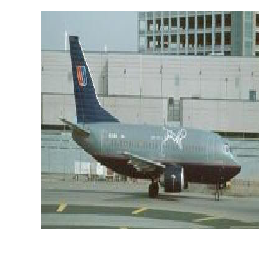

In [141]:
ax, image = imshow_tensor(x)

In [162]:
def predict(image_path, model, topk=3):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]
    
    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

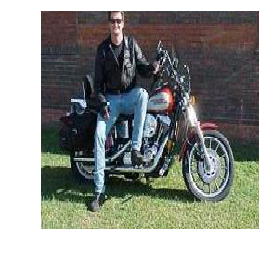

In [163]:
np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = testdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


_ = imshow_tensor(process_image(random_test_image()))

In [156]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
img.shape

planes
planes
datadir/test/planes/image_0611.jpg
tensor([[[[-0.1392, -0.1562, -0.1733,  ..., -0.8386, -0.8727, -0.9068],
          [-0.1392, -0.1562, -0.1733,  ..., -0.8386, -0.8727, -0.9068],
          [-0.1904, -0.2245, -0.2415,  ..., -1.0433, -0.8727, -0.8727],
          ...,
          [ 0.4919,  0.5431,  0.6284,  ...,  0.6625,  0.6796,  0.6796],
          [ 0.0826,  0.0655,  0.0826,  ...,  0.7137,  0.7308,  0.7478],
          [ 0.0826,  0.0655,  0.0826,  ...,  0.7137,  0.7308,  0.7478]],

         [[ 0.3708,  0.3534,  0.3359,  ..., -0.6232, -0.6581, -0.6929],
          [ 0.3708,  0.3534,  0.3359,  ..., -0.6232, -0.6581, -0.6929],
          [ 0.3185,  0.2836,  0.2662,  ..., -0.8673, -0.6929, -0.6929],
          ...,
          [ 0.2662,  0.3185,  0.4057,  ...,  0.3883,  0.4057,  0.4057],
          [-0.1698, -0.1872, -0.1698,  ...,  0.4406,  0.4580,  0.4754],
          [-0.1698, -0.1872, -0.1698,  ...,  0.4406,  0.4580,  0.4754]],

         [[ 0.8171,  0.7997,  0.7824,  ..., -0.6413, 

torch.Size([3, 224, 224])

In [158]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

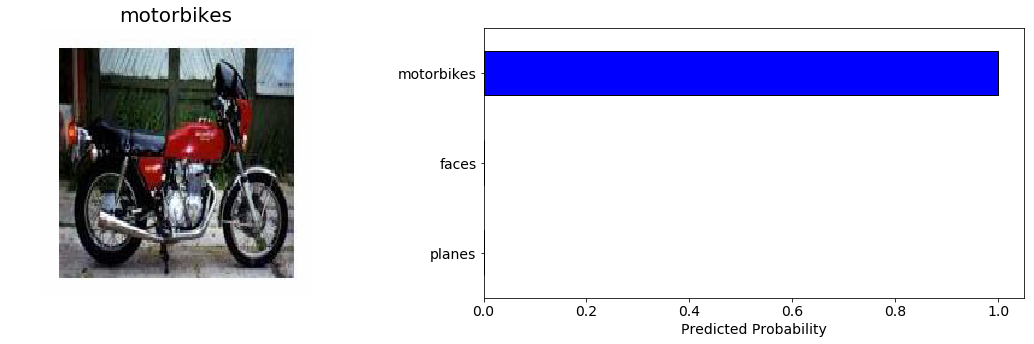

In [164]:
display_prediction(random_test_image(), model, topk=3)

In [165]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [167]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model(features.to('cuda')), targets, topk=(1, 3))
else:
    accuracy(model(features), targets, topk=(1, 3))

In [170]:
def evaluate(model, test_loader, criterion, topk=(1, 3)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

In [171]:
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results = evaluate(model, dataloaders['test'], criterion)
results.head()

,class,top1,top3,loss
0,faces,100.0,100.0,0.000000
1,motorbikes,99.5,100.0,0.019624
2,planes,100.0,100.0,0.000000


        class   top1   top3      loss  n_train_x  n_valid_x  n_test_x  \
0       faces  100.0  100.0  0.000000        245         97        93   
1  motorbikes   99.5  100.0  0.019624        399        199       200   
2      planes  100.0  100.0  0.000000        400        200       200   

   n_train_y  n_valid_y  n_test_y  n_train_x  n_valid_x  n_test_x  n_train_y  \
0        245         97        93        245         97        93        245   
1        399        199       200        399        199       200        399   
2        400        200       200        400        200       200        400   

   n_valid_y  n_test_y  n_train  n_valid  n_test  
0         97        93      245       97      93  
1        199       200      399      199     200  
2        200       200      400      200     200  


/home/mike/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-5, 105)

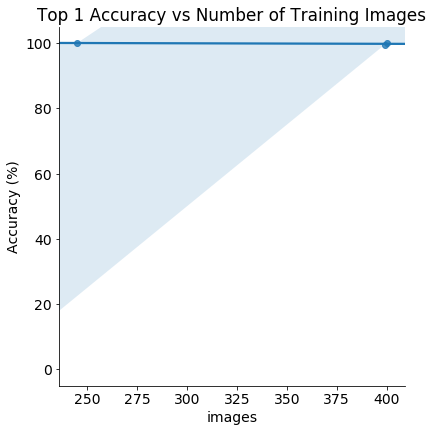

In [176]:
import seaborn as sns

results = results.merge(cat_df, left_on='class', right_on='category').\
    drop(columns=['category'])

# For some reason, this makes the code pass.
print(results)

# Plot using seaborn
sns.lmplot(
    y='top1', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 1 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)

In [177]:
print('Category with minimum accuracy.')
results.loc[results['top1'].idxmin]

print('Category with minimum images.')
results.loc[results['n_train'].idxmin]

Category with minimum accuracy.
Category with minimum images.


class        faces
top1           100
top3           100
loss             0
n_train_x      245
n_valid_x       97
n_test_x        93
n_train_y      245
n_valid_y       97
n_test_y        93
n_train_x      245
n_valid_x       97
n_test_x        93
n_train_y      245
n_valid_y       97
n_test_y        93
n_train        245
n_valid         97
n_test          93
Name: 0, dtype: object

/home/mike/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-5, 105)

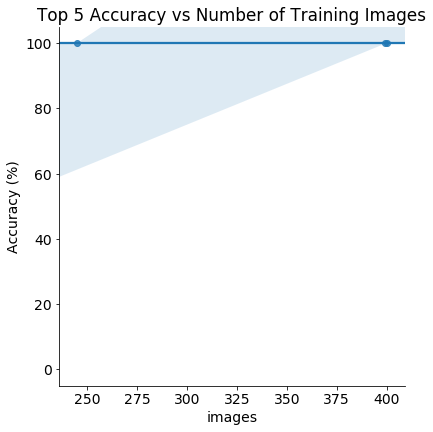

In [179]:
sns.lmplot(
    y='top3', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 5 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)

In [181]:
# Weighted column of test images
results['weighted'] = results['n_test'] / results['n_test'].sum()

# Create weighted accuracies
for i in (1, 3):
    results[f'weighted_top{i}'] = results['weighted'] * results[f'top{i}']

# Find final accuracy accounting for frequencies
top1_weighted = results['weighted_top1'].sum()
top5_weighted = results['weighted_top3'].sum()
loss_weighted = (results['weighted'] * results['loss']).sum()

print(f'Final test cross entropy per image = {loss_weighted:.4f}.')
print(f'Final test top 1 weighted accuracy = {top1_weighted:.2f}%')
print(f'Final test top 3 weighted accuracy = {top5_weighted:.2f}%')

Final test cross entropy per image = 0.0080.
Final test top 1 weighted accuracy = 99.80%
Final test top 3 weighted accuracy = 100.00%


In [185]:
def display_category(model, category, n=4):
    """Display predictions for a category    
    """
    category_results = results.loc[results['class'] == category]
    print(category_results.iloc[:, :6], '/n')

    images = np.random.choice(
        os.listdir(testdir + category + '/'), size=4, replace=False)

    for img in images:
        display_prediction(testdir + category + '/' + img, model, 3)

        class  top1   top3      loss  n_train_x  n_valid_x
1  motorbikes  99.5  100.0  0.019624        399        199 /n


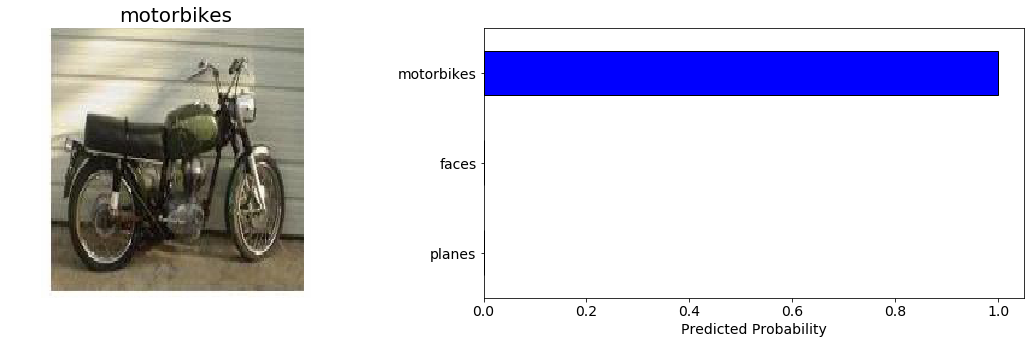

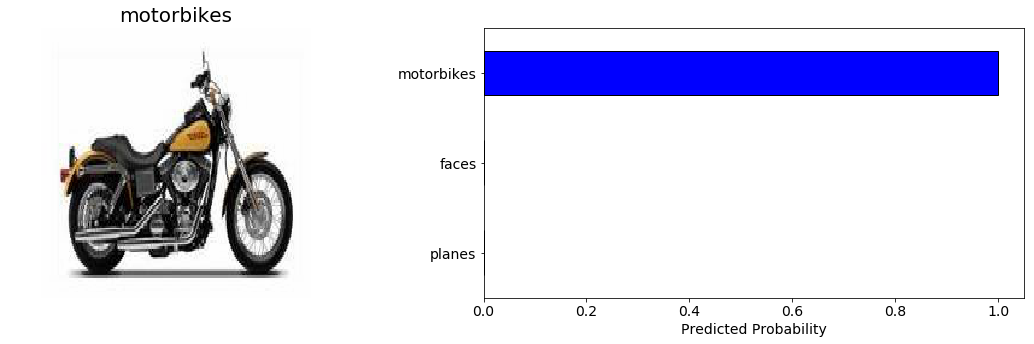

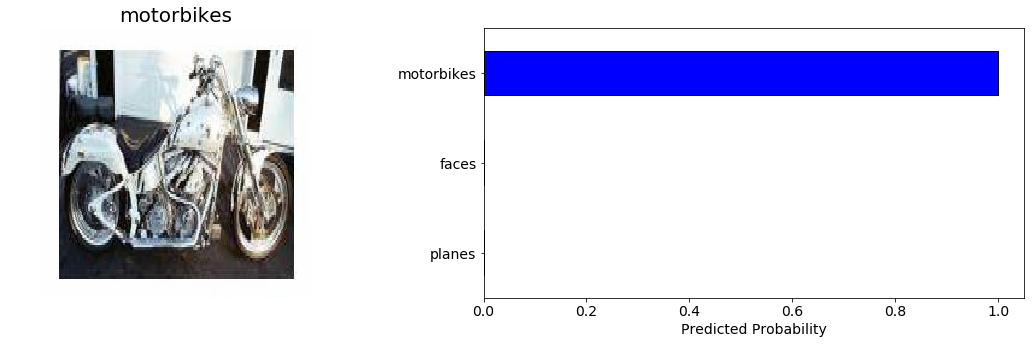

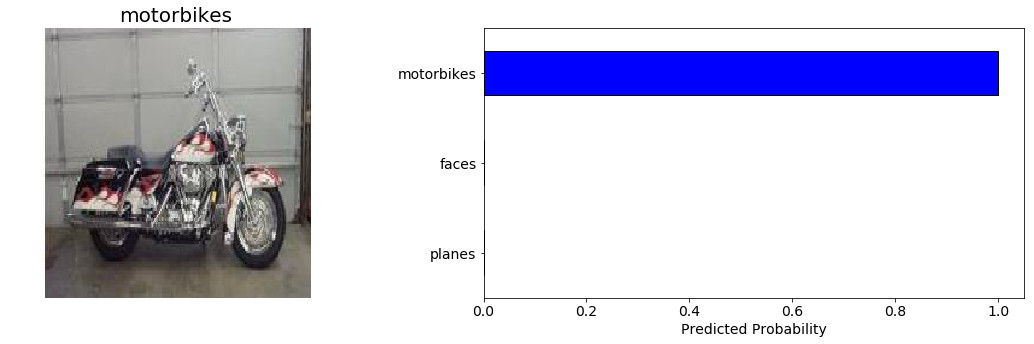

In [187]:
display_category(model, 'motorbikes')

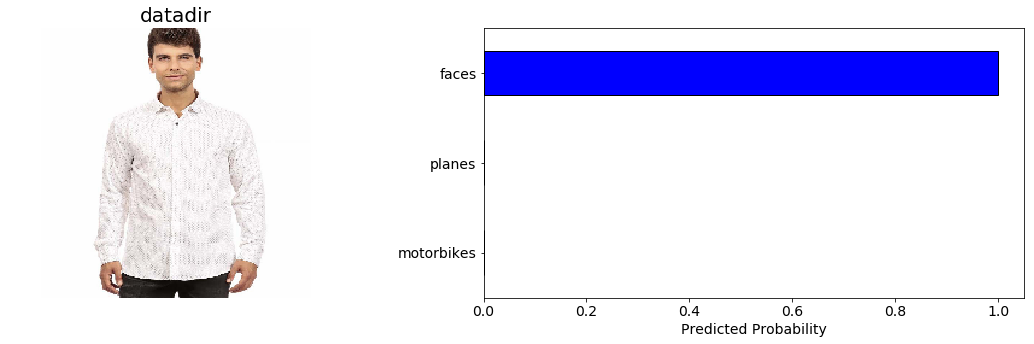

In [189]:
display_prediction('datadir/human.jpg', model, topk=3)

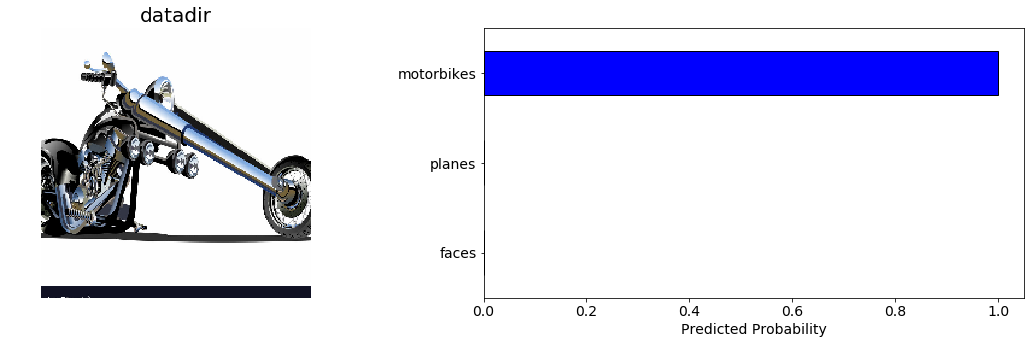

In [190]:
display_prediction('datadir/cartoon-motorbike-vector-1237034.jpg', model, topk=3)

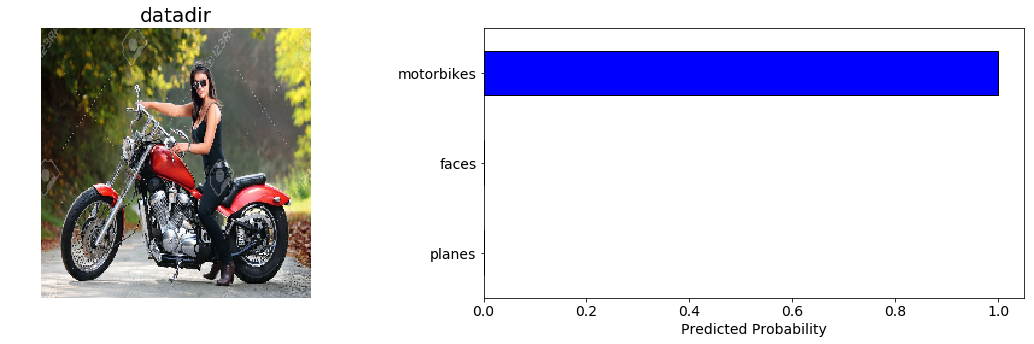

In [195]:
display_prediction('datadir/motor-girl.jpg', model, topk=3)

In [1]:
display_prediction('datadir/france.jpg', model, topk=3)

NameError: name 'display_prediction' is not defined